# Visualization of generated .png Copernicus Hub L1c patches
This notebook visualizes the bands of a generated .png L1C patches of Copernicus Hub that were shifted and cropped to make them similar to the MARIDA patches.

The patches I took from Copernicus Hub are larger than the ones of MARIDA. So, this notebook:
-  computes and matches keypoints between the two patches
-  computes an estimation of the horizontal and vertical shift between the two patches and applies the shift
-  get the center of the marida patch, applies the shift to it, and crops the copernicus hub patch by setting the shifted marida center coordinates as center and size equal to the marida patch size. 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

from anomalymarinedetection.utils.utils import get_coords_of_keypoint

In [16]:
path = '../../anomalymarinedetection/l1c_generation/keypoints_pairs/mar_S2_24-3-20_18QYF_0_B01_cophub_S2_24-3-20_18QYF_0_B01_matches.npz'
npz = np.load(path)
npz.files

cop_hub_img_path = '/data/anomaly-marine-detection/data/l1c_copernicus_hub/images_before_keypoint_matching/cophub_S2_24-3-20_18QYF_0_B01.png'

In [17]:
print(npz['keypoints0'].shape)
print(npz['keypoints1'].shape)
print(npz['matches'].shape)
print(np.sum(npz['matches']>-1))
print(npz['match_confidence'].shape)

(890, 2)
(1024, 2)
(890,)
632
(890,)


In [18]:
def discard_means_out_of_std_dev(diffs_x: list[float], diffs_y: list[float],
                                 mean_diffs_x: float, std_dev_diffs_x: float,
                                 mean_diffs_y: float, std_dev_diffs_y: float):
    """Discards differences whose value is not in the interval [mean_diff - std_dev, mean_diff + std_dev]
    and do this for both horizontal and vertical differences

    Args:
        diffs_x (list[float]): horizontal differences
        diffs_y (list[float]): vertical differences
        mean_diffs_x (float): mean of horizontal differences
        std_dev_diffs_x (float): standard deviation of horizontal differences
        mean_diffs_y (float): mean of vertical differences
        std_dev_diffs_y (float): standard deviation of vertical differences
    """
    i = 0
    while i < len(diffs_x):
        if diffs_x[i] < mean_diffs_x - std_dev_diffs_x or diffs_x[i] > mean_diffs_x + std_dev_diffs_x \
            or diffs_y[i] < mean_diffs_y - std_dev_diffs_y or diffs_y[i] > mean_diffs_y + std_dev_diffs_y:
                del diffs_x[i]
                del diffs_y[i]
        i += 1

In [19]:
# For each keypoint in keypoints0, the matches array indicates the index of 
# the matching keypoint in keypoints1, or -1 if the keypoint is unmatched.
num_matches = 0

diffs_x = []
diffs_y = []

for idx_keypoint_0, idx_keypoint_1 in enumerate(npz['matches']):
    # Consider only keypoints that match
    if idx_keypoint_1 != -1:
        num_matches += 1
        # Get coordinates of matched keypoints
        keypont_0_x, keypont_0_y = get_coords_of_keypoint(npz['keypoints0'][idx_keypoint_0])
        keypont_1_x, keypont_1_y = get_coords_of_keypoint(npz['keypoints1'][idx_keypoint_1])
        # Get signed horizontal and vertical differences of corrdinates of matched keypoints
        diff_x = keypont_0_x - keypont_1_x
        diff_y = keypont_0_y - keypont_1_y
        # Update lists of differences
        diffs_x.append(diff_x)
        diffs_y.append(diff_y)
# Compute the mean of horizontal and vertical differences
mean_diffs_x = np.mean(diffs_x)
mean_diffs_y = np.mean(diffs_y)
print(mean_diffs_x, mean_diffs_y)
print(diffs_x)
print(diffs_y)
# Compute the std dev of horizontal and vertical differences
std_dev_diffs_x = np.std(diffs_x)
std_dev_diffs_y = np.std(diffs_y)
print(std_dev_diffs_x)
print(std_dev_diffs_y)
# Discard differences whose value is not in the interval [mean_diff - std_dev, mean_diff + std_dev]
# and do this for both horizontal and vertical differences
discard_means_out_of_std_dev(diffs_x, diffs_y, 
                             mean_diffs_x, std_dev_diffs_x,
                             mean_diffs_y, std_dev_diffs_y)
# Recompute the mean of the horizontal and vertical differences and round it to the nearest integer
# (since we use pixels)
mean_diffs_x = round(np.mean(diffs_x))
mean_diffs_y = round(np.mean(diffs_y))
print(mean_diffs_x, mean_diffs_y)
print(diffs_x)
print(diffs_y)
        
print(f"Total of {num_matches} matches")

-20.04114 -18.058544
[-19.0, -20.0, -20.0, -20.0, -20.0, -21.0, -21.0, -20.0, -21.0, -20.0, -20.0, -20.0, -21.0, -20.0, -21.0, -20.0, -20.0, -20.0, -21.0, -21.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -19.0, -21.0, -20.0, -21.0, -20.0, -20.0, -21.0, -20.0, -19.0, -21.0, -19.0, -20.0, -19.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -21.0, -19.0, -19.0, -20.0, -20.0, -21.0, -20.0, -20.0, -19.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -21.0, -21.0, -20.0, -19.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -21.0, -20.0, -20.0, -20.0, -20.0, -20.0, -19.0, -20.0, -20.0, -20.0, -20.0, -21.0, -20.0, -20.0, -20.0, -20.0, -20.0, -19.0, -20.0, -19.0, -20.0, -20.0, -21.0, -20.0, -20.0, -19.0, -20.0, -21.0, -20.0, -19.0, -20.0, -20.0, -20.0, -20.0, -19.0, -20.0, -19.0, -20.0, -20.0, -21.0, -19.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -19.0, -20.0, -20.0, -20.0, -19.0, -20.0, -20.0, -21.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -20.0

(296, 296)


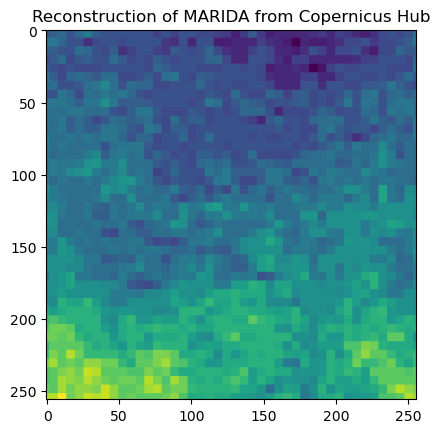

(256, 256)


In [20]:
# Crop a Copernicus Hub patch according to its shift compared to its corresponding MARIDA patch
# To do this:
# 1. get coordinates of the center of the MARIDA patch
# 2. shift them (horizontally and vertically) by the mean of differences previously computed 
# 3. crop the Copernicus Hub patch by considering the shifted center coordinates and the size of the MARIDA patch
MARIDA_SIZE_X = 256
MARIDA_SIZE_Y = 256
HALF_MARIDA_SIZE_X = round(MARIDA_SIZE_X / 2)
HALF_MARIDA_SIZE_Y = round(MARIDA_SIZE_Y / 2)
# Read Copernicus Hub patch 
cop_hub_img = cv.imread(cop_hub_img_path, cv.IMREAD_GRAYSCALE)
print(cop_hub_img.shape)
# 1. get coordinates of the center of the MARIDA patch
center_marida_x = HALF_MARIDA_SIZE_X
center_marida_y = HALF_MARIDA_SIZE_Y
# 2. shift them (horizontally and vertically) by the mean of differences previously computed 
corresponding_center_cop_hub_x = center_marida_x - mean_diffs_x
corresponding_center_cop_hub_y = center_marida_y - mean_diffs_y
# 3. crop the Copernicus Hub patch by considering the shifted center coordinates and the size of the MARIDA patch
cop_hub_2_marida_img = \
    cop_hub_img[
        corresponding_center_cop_hub_y - HALF_MARIDA_SIZE_Y:
        corresponding_center_cop_hub_y + HALF_MARIDA_SIZE_Y,
        corresponding_center_cop_hub_x - HALF_MARIDA_SIZE_X:
        corresponding_center_cop_hub_x + HALF_MARIDA_SIZE_X
        ]

plt.imshow(cop_hub_2_marida_img)
plt.title("Reconstruction of MARIDA from Copernicus Hub")
plt.show()
print(cop_hub_2_marida_img.shape)